In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (7.0, 5.5)

from astropy import units
from galpy.orbit import Orbit
from FerrersPotential import FerrersPotential as FP

# ======================  useful functions  =========================

In [84]:
def rot(omega, t):
    temp = [[np.cos(t*omega), np.sin(t*omega)], [-np.sin(t*omega), np.cos(t*omega)]]
    return np.array(temp)

def inrotframe(x,y, ts, potential):
    xy = np.zeros([len(x),2])
    xy[:,0] = x
    xy[:,1] = y
    omega = potential.OmegaP()
    xrot, yrot = np.zeros(len(ts)), np.zeros(len(ts))
    for i in range(len(ts)):
        xrot[i],yrot[i] = np.dot(xy[i],rot(omega, ts[i]))
    return xrot, yrot

In [96]:
def allorbits(x,y):
    xo = [x[3*i] for i in range(int(len(x)/3))]
    xo1 = [x[3*i+1] for i in range(int(len(x)/3))]
    xo2 = [x[3*i+2] for i in range(int(len(x)/3))]
    yo = [y[3*i] for i in range(int(len(x)/3))]
    yo1 = [y[3*i+1] for i in range(int(len(x)/3))]
    yo2 = [y[3*i+2] for i in range(int(len(x)/3))]
    return [xo,yo],[xo1,yo1],[xo2,yo2]

In [60]:
# function for normalization of vectors because numpy version is more than 2 times slower!! - but there are other
# complications which make this approach almost just as efficient
def norm(vec):
    temp = 0
    for item in vec:
        temp += item*item
    temp = math.sqrt(temp)
    for i in range(len(vec)):
        vec[i] = vec[i]/temp
    return vec

def substr(vec1,vec2):
    temp = []
    for i in range(len(vec1)):
        temp.append(vec1[i]-vec2[i])
    return temp

def add(vec1,vec2):
    temp = []
    for i in range(len(vec1)):
        temp.append(vec1[i]+vec2[i])
    return temp

def vsize(vec):
    temp = 0
    for item in vec:
        temp += item*item
    return math.sqrt(temp)

# ===========================  SALI  =============================

Set the stopping flag, SF ← 0, the counter, i ← 1, and the orbit
characterization variable, OC ← ‘regular’.
While ( SF = 0) Do
Evolve the orbit and the deviation vectors from time t = (i − 1) τ
to t = i τ , i. e. Compute x(i τ ) and w 1 (i τ ), w 2 (i τ ).
Normalize the two vectors, i.e.
Set w 1 (i τ ) ← w 1 (i τ )/kw 1 (i τ )k and w 2 (i τ ) ← w 2 (i τ )/kw 2 (i τ )k.
Compute and Store the current value of the SALI:
SALI(i τ ) = min{kw 1 (i τ ) + w 2 (i τ )k, kw 1 (i τ ) − w 2 (i τ )k}.
Set the counter i ← i + 1.
If [SALI((i − 1) τ ) < S m ] Then
Set SF ← 1 and OC ← ‘chaotic’.
End If
If [(i τ > T M )] Then
Set SF ← 1.
End If
End While
Report the time evolution of the SALI and the nature of the orbit.

In [41]:
""" #1
name: devolist
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    in other than first iteration also 'indev', a list which contains normalized deviation vectors from previous
    iteration to be applied to the current state of the Orbit
    WARNING: Due to the method of creating the deviation vectors none of the coordinates can be zero!
             Otherwise at least two of them are linearly dependent!
output:
    list of initial conditions for deviated orbit; devos
"""
def devolist(icon, indev=None):
    devos = [] 
    if indev == None:
        reldev = 0.01
        dorb = icon[:]
        for i in range(2):
            dorb = icon[:]
            dorb[i] += dorb[i]*reldev
            devos.append(dorb)
    else:
        for i in range(2):
            dorb = icon[:]
            dorb = list(np.array(devo)+np.array(indev[i]))
            devos.append(devo)
    return devos
# test
#print(vectlist([1,0.25,0.7,0,0.0,0]))#, indev = [[1,0,0,0,0,0],[0,1,0,0,0,0]))

In [42]:
""" #2
name: evolveorbit
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    final time; tf
    potential; pot
output:
    list of orbit parameters in time tf;
"""
x = []
y = []
def evolveorbit(icon, tf, pot):
    global x
    global y
    o = Orbit(vxvv=icon) # [R,vR,vT,z,vz,phi]
    ts = np.linspace(0.,tf,10)
    o.integrate(ts, pot, method = 'leapfrog')
    #print(o.x(ts[0]), o.y(ts[0]))
    x.append(o.x(ts[0]))
    y.append(o.y(ts[0]))
    #return [o.R(tf),o.vR(tf),o.vT(tf),o.z(tf),o.vz(tf),o.phi(tf)] #for Ferrers potential
    return [o.R(ts[-1]),o.vR(ts[-1]),o.vT(ts[-1]),o.phi(ts[-1])]

In [43]:
""" #3
name: dvector
input:
    evolved orbit o and deviated orbit d
output:
    deviation vector w
"""
def dvector(o,d):
    return np.array(d)-np.array(o)

In [204]:
%%prun -s cumulative
"""
name: sali
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
output:
    current value of sali, new IC for the Orbit, normalized dev. vectors in matrix for next step 
"""
def sali(o, tau, potential, w=None):
    if type(w) == type(None):
        v = devolist(list(o), indev = w)#deviated orbits from the Orbit
    else:
        v = w
    newo = evolveorbit(o, tau, potential) #evolves the Orbit
    wj, wjnorm = [], []
    for dorbit in v:
        temp = evolveorbit(dorbit + o*(type(w) != type(None)), tau, potential) #evolves the deviated orbits to time tau
        item = dvector(o=newo,d=temp)
        wj.append(item)#creates list of deviation vectors in time tau
        wjnorm.append(item/np.linalg.norm(item))
    wj = np.array(wj)
    wjnorm = np.array(wjnorm)
    salivalue = min([np.linalg.norm(wjnorm[0]+wjnorm[1]), np.linalg.norm(wjnorm[0]-wjnorm[1])])
    return salivalue, newo, np.array(wj), o,v #returns value of sali, new IC for the Orbit, x-normalized-x dev. vectors in matrix 


icon = np.array([1,0.25,0.7,0.0])
test = sali(icon, 0.001, pmw)
print(test)

(1.4113396879983819, [1.0002497450934833, 0.24949027750905972, 0.69982509449169505, 0.00069982511923506816], array([[  1.00000153e-02,   3.06029188e-05,   1.73413973e-06,
         -6.92725045e-06],
       [  2.50000093e-06,   2.50000277e-03,  -1.74911966e-06,
         -1.74935784e-09]]), array([ 1.  ,  0.25,  0.7 ,  0.  ]), [[1.01, 0.25, 0.69999999999999996, 0.0], [1.0, 0.2525, 0.69999999999999996, 0.0]])
 

#%%prun -s cumulative
import math
"""
name: sali
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
output:
    current value of sali, new IC for the Orbit, normalized dev. vectors in matrix for next step 
"""
def sali(o, tau, potential, w=None):
    if type(w) == type(None):
        v = devolist(list(o), indev = w)#deviated orbits from the Orbit
    else:
        v = w
    newo = evolveorbit(o, tau, potential) #evolves the Orbit
    wj, wjnorm = [], []
    for dorbit in v:
        temp = evolveorbit(dorbit + o*(type(w) != type(None)), tau, potential) #evolves the deviated orbits to time tau
        item = dvector(o=newo,d=temp)
        wj.append(item)#creates list of deviation vectors in time tau
        wjnorm.append(item/norm(item))
    a = substr((wjnorm[0]),wjnorm[1])
    b = add(wjnorm[0],wjnorm[1])
    salivalue = [vsize(norm(a)), vsize(norm(b))]
    #min(vsize(norm(substr((wjnorm[0]),wjnorm[1])),2)
    return salivalue, newo, wj, o,v #returns value of sali, new IC for the Orbit, x-normalized-x dev. vectors in matrix 


icon = np.array([1,0.25,0.7,0.1])
test = sali(icon, 0.001, pmw)
print(test)

In [81]:
"""
name: salievol
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
    maximum time Tm and small treshold value of the SALI Gm
output:
    42 (and list of SALI values during the integration) 
"""
def salievol(o,tau, potential, Tm, Gm):
    salis = np.zeros([1+int(Tm/tau),2]) # array large enough
    continuing = True # stopping flag
    i = 1 # counter
    w = None #initial setting
    while continuing:
        salis[i-1][1], newo, a, O,v = sali(o, tau, potential, w)
        salis[i-1][0] = tau*i
        if salis[i-1][1]<Gm:
            print('if this code works, the orbit is chaotic')
            continuing = False
            return salis[:i-1][:]
        if i*tau > Tm:
            print('time reached treshold, orbit is regular if this code works')
            continuing = False
            return salis[:][:]
        i += 1
        o = newo
        w = a

In [106]:
%%prun -s cumulative
Tm=12000. # 
tau = 5*10**-2
Gm = 10**-18
# orbit in rotating Ferrers Potential
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1.,0.25,0.6,0.])
results = salievol(icon, tau, pmw, Tm, Gm)

time reached treshold, orbit is regular if this code works
 

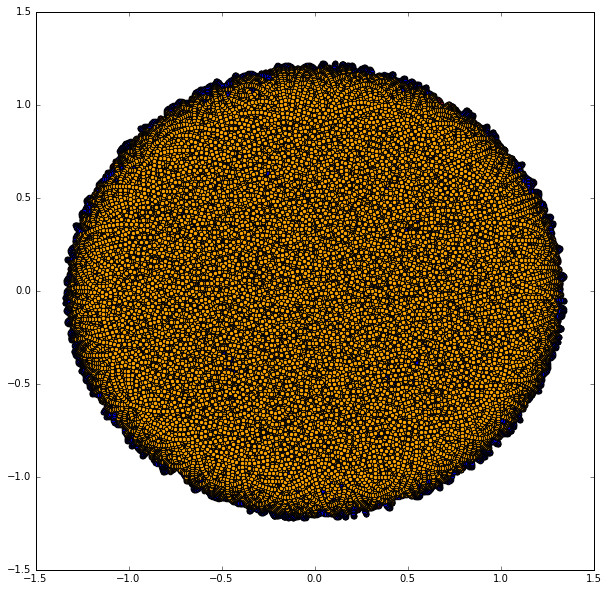

In [101]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
[xo,yo],[xo1,yo1],[xo2,yo2] = allorbits(x,y)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(xo[:], yo[:], c = 'crimson')
plt.scatter(xo1[:], yo1[:], c = 'blue')
plt.scatter(xo2[:], yo2[:], c = 'orange')

plt.show()

(-1.5, 4)

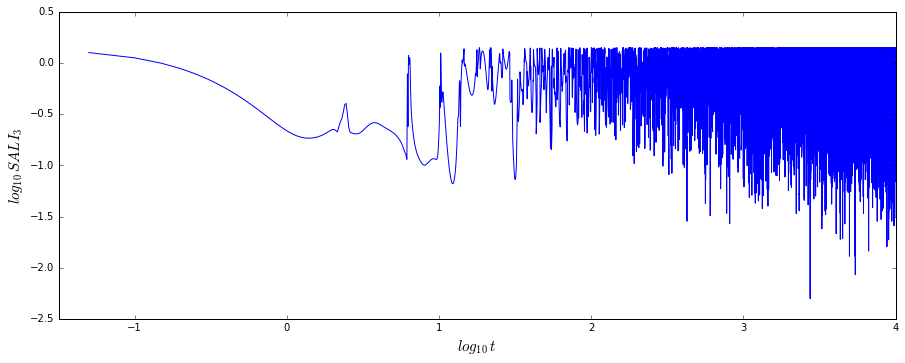

In [206]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.plot(np.log10(results[:,0]), np.log10(results[:,1]), c= 'blue')
plt.xlabel(r'$log_{10}\,t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,SALI_3$', fontsize = 15)
plt.xlim(-1.5,4)

(-16, 1)

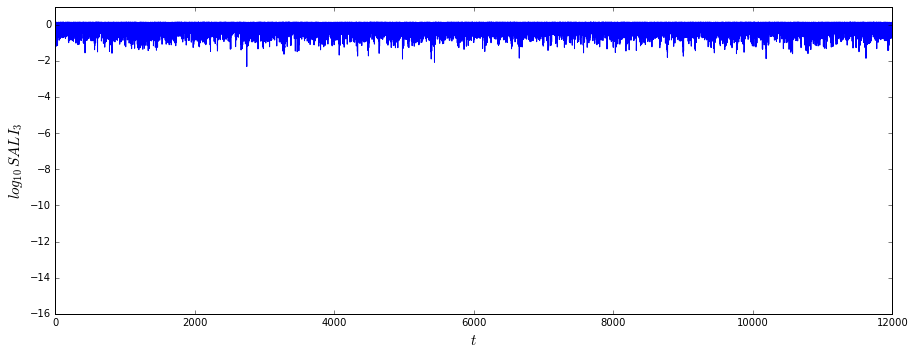

In [202]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.plot((results[:,0]), np.log10(results[:,1]), c= 'blue')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,SALI_3$', fontsize = 15)
plt.xlim(0,12000)
plt.ylim(-16,1)

(4000, 4100)

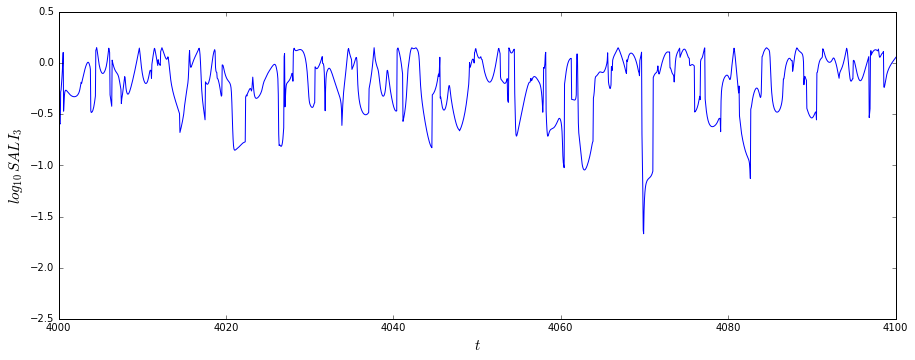

In [201]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.plot((results[:,0]), np.log10(results[:,1]), c= 'blue')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,SALI_3$', fontsize = 15)
plt.xlim(4000,4100)

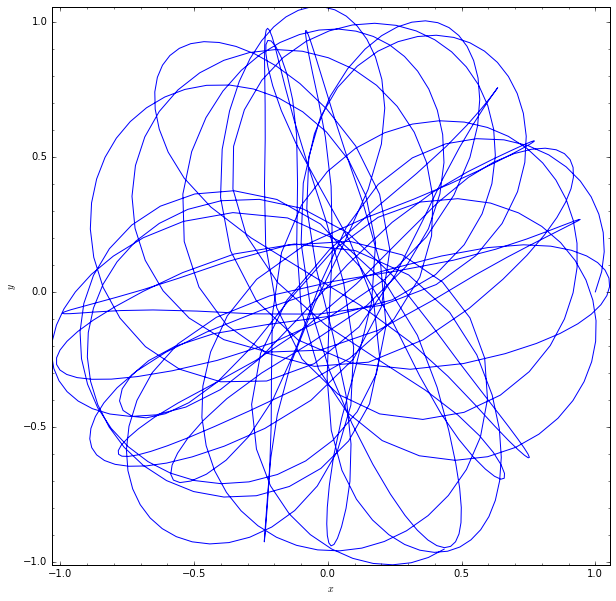

In [90]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
orb = Orbit(vxvv = [1.,0.25,0.6,0.])
timespan = np.linspace(0,100,800)
orb.integrate(timespan, pmw, method = 'leapfrog')
orb.plot(d1 = 'x', d2 = 'y')
#plt.xlim(-0.5,0.5)
#plt.ylim(-0.3,0.3)

In [166]:
#%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,68,1000)
omwa = Orbit(vxvv=[0.4,0.238,0.7,0,0.0,0])
omwa1 = Orbit(vxvv=[1,0.238,0.698,0,0.0,0])
omwa2 = Orbit(vxvv=[1,0.238,0.697,0,0.0,0])
omwa.integrate(ts, pmw, method = 'leapfrog')
#omwa1.integrate(ts, pmw, method = 'leapfrog')
omwa2.integrate(ts, pmw, method = 'leapfrog')

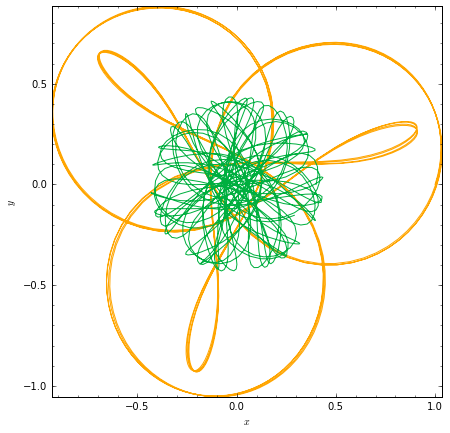

In [167]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
omwa2.plot(d1 = 'x', d2 = 'y',color = 'orange', overplot = False)
omwa.plot(d1 = 'x', d2 = 'y',color = '#00AF3F', overplot = True)
#omwa1.plot(d1 = 'x', d2 = 'y',color = 'crimson')#, overplot = True)

In [168]:
xai,yai = [],[]
for i in ts:
    xai.append(omwa.x(i))
    yai.append(omwa.y(i))
    
xar, yar = inrotframe(xai,yai,ts,pmw)
plt.plot(xar,yar)

In [171]:
#%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,68,1000)
omwb = Orbit(vxvv=[0.2,0.238,0.7,0,0.0,0])
#omwb1 = Orbit(vxvv=[1,0.238,0.698,0,0.0,0])
#omwb2 = Orbit(vxvv=[1,0.238,0.697,0,0.0,0])
omwb.integrate(ts, pmw, method = 'leapfrog')
#omwb1.integrate(ts, pmw, method = 'leapfrog')
#omwb2.integrate(ts, pmw, method = 'leapfrog')

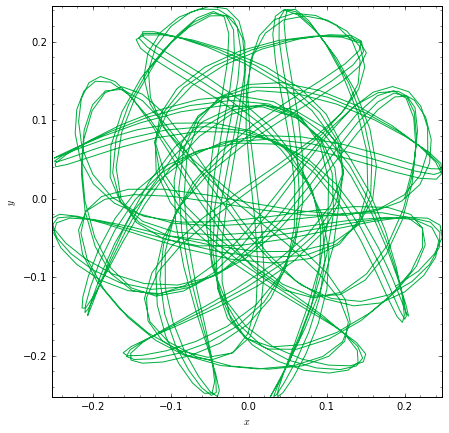

In [173]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
#omwb2.plot(d1 = 'x', d2 = 'y',color = 'orange', overplot = False)
omwb.plot(d1 = 'x', d2 = 'y',color = '#00AF3F')#, overplot = True)
#omwb1.plot(d1 = 'x', d2 = 'y',color = 'crimson')#, overplot = True)

In [177]:
#%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,68,1000)
omwc = Orbit(vxvv=[0.2,0.238,0.5,0,0.0,0])
#omwc1 = Orbit(vxvv=[1,0.238,0.698,0,0.0,0])
#omwc2 = Orbit(vxvv=[1,0.238,0.697,0,0.0,0])
omwc.integrate(ts, pmw, method = 'leapfrog')
#omwc1.integrate(ts, pmw, method = 'leapfrog')
#omwc2.integrate(ts, pmw, method = 'leapfrog')

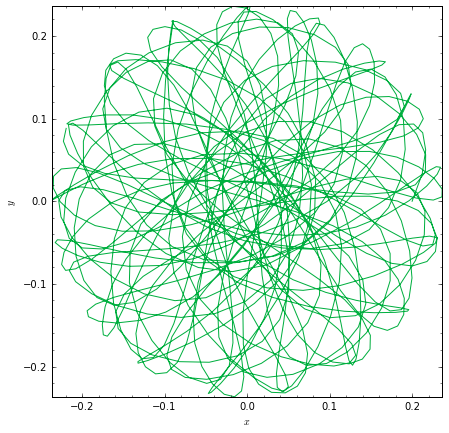

In [178]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
#omwc2.plot(d1 = 'x', d2 = 'y',color = 'orange', overplot = False)
omwc.plot(d1 = 'x', d2 = 'y',color = '#00AF3F')#, overplot = True)
#omwc1.plot(d1 = 'x', d2 = 'y',color = 'crimson')#, overplot = True)

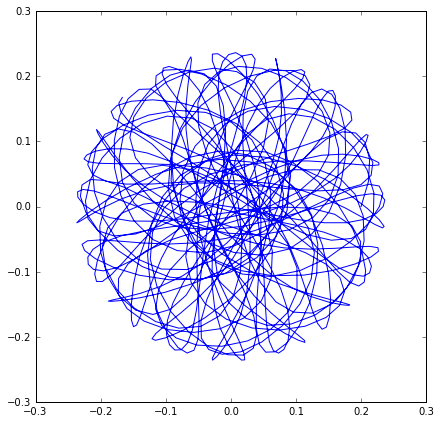

In [179]:
xci,yci = [],[]
for i in ts:
    xci.append(omwc.x(i))
    yci.append(omwc.y(i))
    
xcr, ycr = inrotframe(xci,yci,ts,pmw)
plt.plot(xcr,ycr)

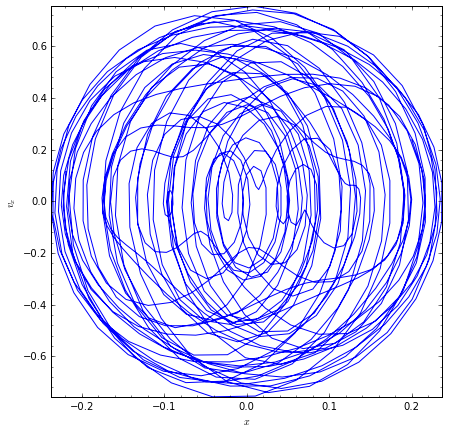

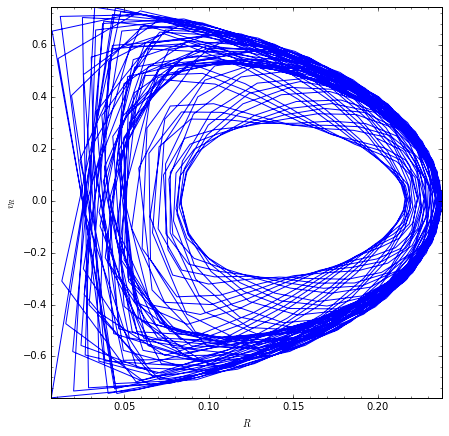

In [184]:
omwc.plot(d1 = 'x', d2 = 'vx')
omwc.plot(d1 = 'R', d2 = 'vR')

In [186]:
omwd = Orbit(vxvv = [0.5,0.2,0.4,0.,0.,3*np.pi/10])
ts = np.linspace(0,68,1000)
omwd.integrate(ts, pmw, method ='leapfrog')

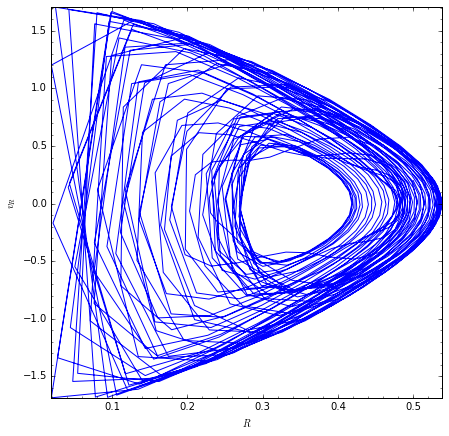

In [188]:
omwd.plot(d1 = 'R', d2 = 'vR')

In [199]:
vz = 0.03*16
omwe = Orbit(vxvv = [0.5,0.1,0.6,0.,vz,np.pi/4])
ts = np.linspace(0,500,10000)
omwe.integrate(ts, pmw, method = 'leapfrog')

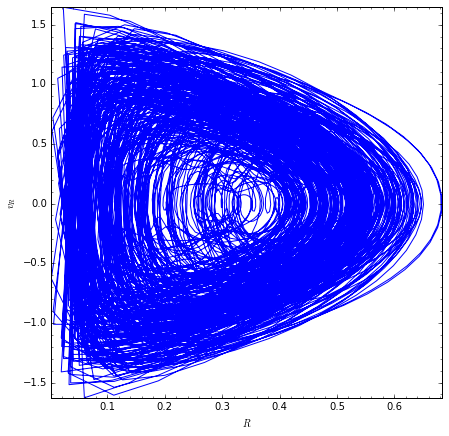

In [200]:
omwe.plot(d1 = 'R', d2 = 'vR')